1. Познакомьтесь с данными.
2. Осуществите предобработку данных.
    - 2.1 Приведите заголовки к удобному виду.
    - 2.2 Проверьте типы данных.
    - 2.3 Обработайте пропуски.
    - 2.4 Проверьте наличие дубликатов.
    - 2.5 Исключите нулевые значения в выручке для дальнейшего исследования.
3. Исследовательский анализ данных:
     - 3.1 Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.
     - 3.2 Исследуйте выручку, примите решение об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.
     - 3.3 Исследуйте сезонность продаж. Дополнительно проверьте гипотезу о том, что выручка от продаж осенью и зимой отличается. Исследуйте выручку и число продаж по месяцам, проверьте корреляцию.
     - 3.4 Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверьте гипотезу о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительно разбейте клиентов минимум на три группы.
     - 3 .5  Определите топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучите выручку для этих направлений. Для этого добавьте в датасет сведения о городах, используя данные из датасета:
     https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
     - 3.6 Определите есть ли зависимость выручки от других признаков. Постройте матрицу корреляций.

Каждый пункт исследования сопроводите выводами.


In [2]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st

In [3]:
plt.rcParams['figure.figsize'] = (12,6)
sns.set_theme(style = 'whitegrid', palette = 'hsv')

# 1. Знакоство с данными

In [4]:
df = pd.read_csv('air_data.csv',sep = ';')
df.head()

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
4,2021-12-08 00:00:00,2022-01-12 00:00:00,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE


# 2. Предобработка данных

2.1 Приведем заголовки к удобному виду

In [5]:
# Как было раньше видно, все заголовки прописаны заглавными буквами, поэтому следует снизить их регистр для удобства работы
df.columns = df.columns.str.lower()

2.2 Проверим типы данных и преобразуем по необходимости

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   issue_date         50000 non-null  object
 1   flight_date_loc    50000 non-null  object
 2   pax_type           50000 non-null  object
 3   revenue_amount     50000 non-null  int64 
 4   orig_city_code     49998 non-null  object
 5   dest_city_code     49999 non-null  object
 6   route_flight_type  50000 non-null  object
 7   ffp_flag           19398 non-null  object
 8   sale_type          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


Столбцы с датами непреобразованы

In [7]:
for col in df.columns[:2]:
    df[col] = pd.to_datetime(df[col])

2.3 Обработка пропусков

In [8]:
#Посмотрим сколько значений пропущено
df['ffp_flag'].value_counts(dropna = False)

ffp_flag
NaN    30602
FFP    19398
Name: count, dtype: int64

In [9]:
# Как  мы видим, отсутствие системы лояльности просто не поописывается, заменим ее на NO
df['ffp_flag'] = df['ffp_flag'].fillna('NO')

In [10]:
# Так как восстановление оригинального кода городов трудоемкое дело
#а пропуски относительно всего датасета составляю незначительную часть -  удалим их
df = df.dropna().reset_index(drop = True)

2.4 Проверка наличия дубликатов

In [11]:
df.duplicated().sum()

169

In [12]:
# Удалим дубликаты
df.drop_duplicates(inplace = True)

2.5 Исключим нулевые значения в выручке для дальнейшего исследования

In [13]:
df = df.query('revenue_amount > 0')

# 3 Исследовательский анализ данных

## 3.1 Создадим отчет о динамике продаж

In [14]:
#Нам понадобится вычислительный столбец c годом и месяцем
df['year_month'] = df['issue_date'].dt.strftime('%Y-%m')

In [15]:
#Создадим сводный помесячный отчет
report_gen = df.pivot_table(index = 'year_month',
                        values = 'revenue_amount',
                        aggfunc = 'sum').reset_index()
report_gen

,year_month,revenue_amount
0,2021-10,1327840
1,2021-11,1851260
2,2021-12,1757250
3,2022-01,1352390
4,2022-02,1347770
5,2022-03,1826430
6,2022-04,2032570
7,2022-05,1713360
8,2022-06,1614500
9,2022-07,2638430


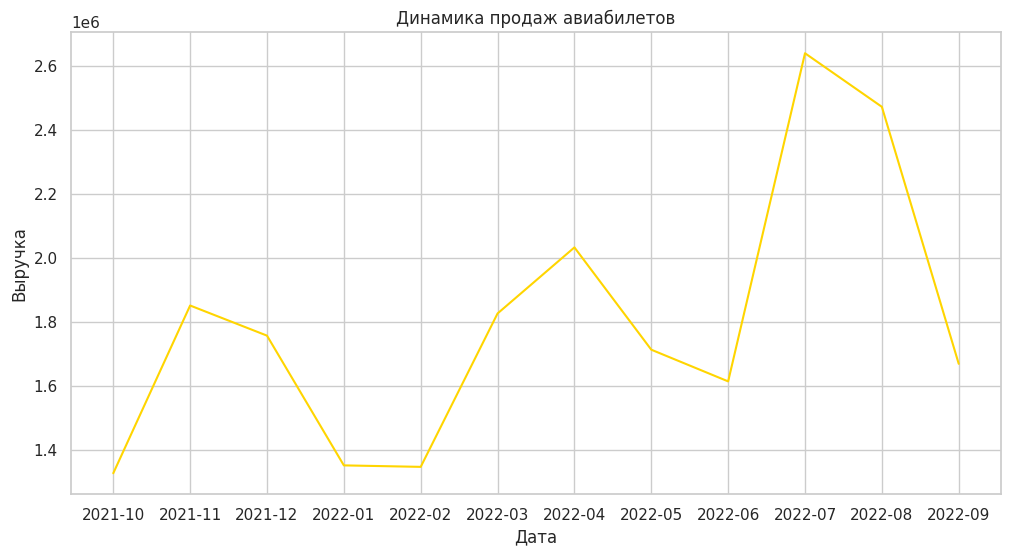

In [16]:
sns.lineplot(data = report_gen, x = 'year_month', y = 'revenue_amount').set(title = 'Динамика продаж авиабилетов',
                                                                   xlabel = 'Дата',
                                                                    ylabel = 'Выручка')
plt.show()

В среднем выручка растет, наблюдается сезонность колебаний

In [17]:
#Создадим сводный помесячный отчет с детализацией по лояльности
report_loyal = df.pivot_table(index = 'year_month',
                        values = 'revenue_amount',
                        aggfunc = 'sum',
                         columns = 'ffp_flag').reset_index()
report_loyal

ffp_flag,year_month,FFP,NO
0,2021-10,502030,825810
1,2021-11,735100,1116160
2,2021-12,721010,1036240
3,2022-01,538540,813850
4,2022-02,499240,848530
5,2022-03,801360,1025070
6,2022-04,764880,1267690
7,2022-05,649520,1063840
8,2022-06,590920,1023580
9,2022-07,973450,1664980


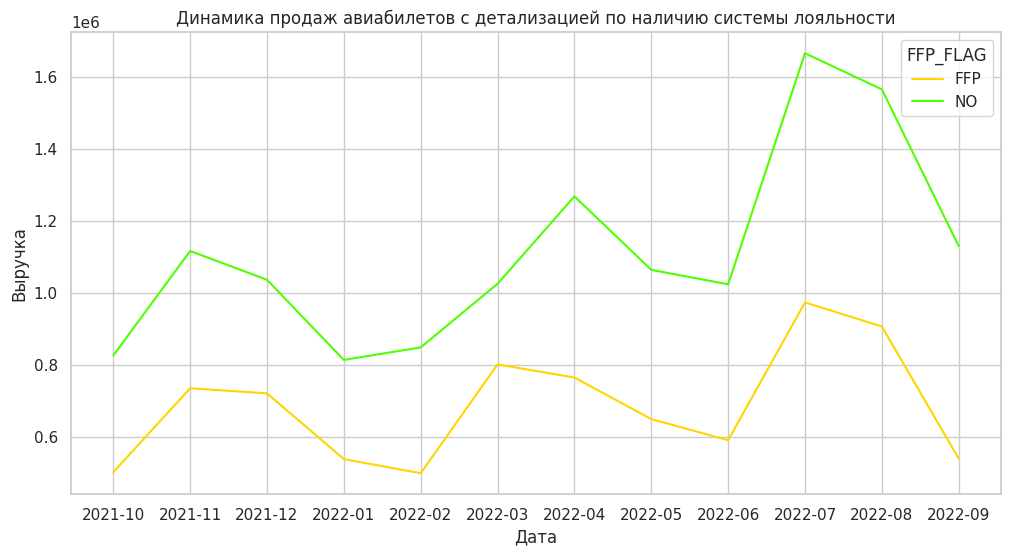

In [18]:
for col in report_loyal.columns[1:]:
    sns.lineplot(data = report_loyal, x = 'year_month', y = col, label = col)
plt.legend(title = 'FFP_FLAG')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Динамика продаж авиабилетов с детализацией по наличию системы лояльности')
plt.show()

Динамика схожая, только люди с системой лояльности платят меньше, что вполне ожидаемо (так как их банально меньше)

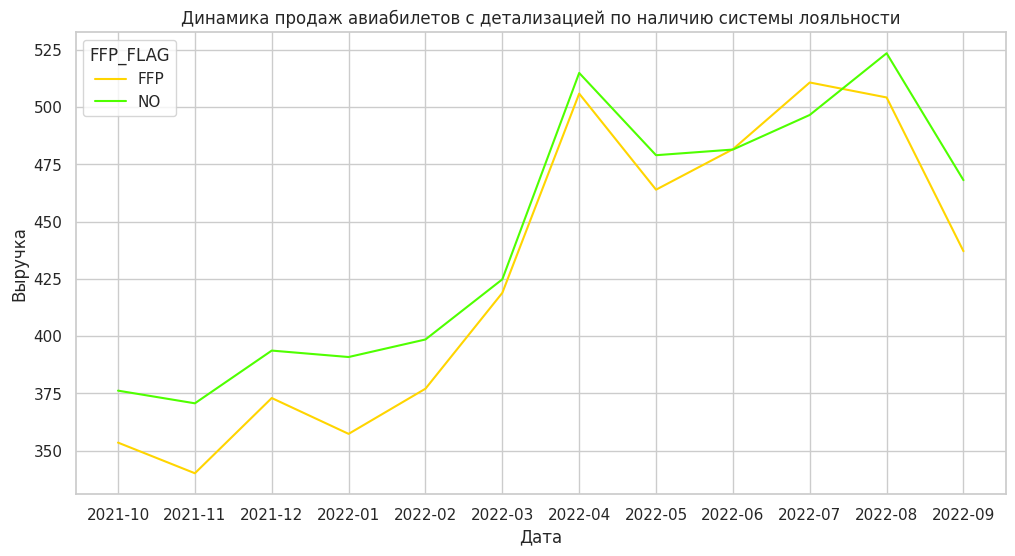

In [19]:
# Посмотрим, как обстоит дела со средней выручкой по категориям лояльности
report_loyal2 = df.pivot_table(index = 'year_month',
                        values = 'revenue_amount',
                        aggfunc = 'mean',
                         columns = 'ffp_flag').reset_index()
for col in report_loyal.columns[1:]:
    sns.lineplot(data = report_loyal2, x = 'year_month', y = col, label = col)
plt.legend(title = 'FFP_FLAG')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Динамика продаж авиабилетов с детализацией по наличию системы лояльности')
plt.show()

Тут уже ситуация немного другая, несмотря на скидки люди с системой лояльности приносят компаниям примерно столько же денег, как и люди без скидок

In [20]:
# Посмотрим, как обстоит дела со средней выручкой по категориям пассажиров
report_type = df.pivot_table(index = 'year_month',
                        values = 'revenue_amount',
                        aggfunc = 'mean',
                         columns = 'pax_type').reset_index()
report_type

pax_type,year_month,AD,CHD,INF
0,2021-10,371.004471,328.744939,147.692308
1,2021-11,360.922441,323.496933,67.272727
2,2021-12,388.946141,327.333333,113.333333
3,2022-01,379.638733,335.217391,192.000000
4,2022-02,393.723537,351.794872,115.714286
5,2022-03,425.418829,378.405797,106.666667
6,2022-04,515.171205,470.739300,102.500000
7,2022-05,477.909938,442.780612,102.222222
8,2022-06,485.564621,449.285714,103.333333
9,2022-07,517.120341,375.250000,102.500000


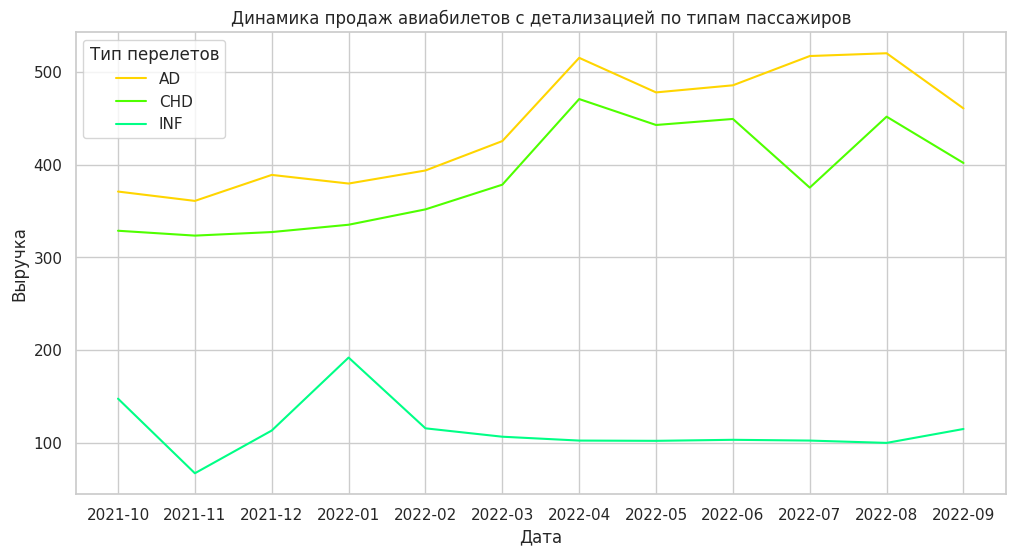

In [21]:
for col in report_type.columns[1:]:
    sns.lineplot(data = report_type, x = 'year_month', y = col, label = col)
plt.legend(title = 'Тип перелетов')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Динамика продаж авиабилетов с детализацией по типам пассажиров')
plt.show()

Взрослые плятят больше всех, а люди неотносящиеся к взрослым и детям платят меньше всех (может быть это сотрудники)

In [22]:
df['route_flight_type'].value_counts()

route_flight_type
ВВЛ    45468
МВЛ     3894
Name: count, dtype: int64

In [23]:
# Посмотрим, как обстоит дела со средней выручкой по категориям перелетов
report_type = df.pivot_table(index = 'year_month',
                        values = 'revenue_amount',
                        aggfunc = 'mean',
                         columns = 'route_flight_type').reset_index()
report_type

route_flight_type,year_month,ВВЛ,МВЛ
0,2021-10,340.327547,513.914591
1,2021-11,336.189534,516.458333
2,2021-12,366.510220,506.262458
3,2022-01,360.810642,506.598985
4,2022-02,374.639208,543.302181
5,2022-03,421.247940,473.291139
6,2022-04,511.667995,507.846890
7,2022-05,473.827876,459.882353
8,2022-06,482.218354,469.896373
9,2022-07,501.760704,500.498084


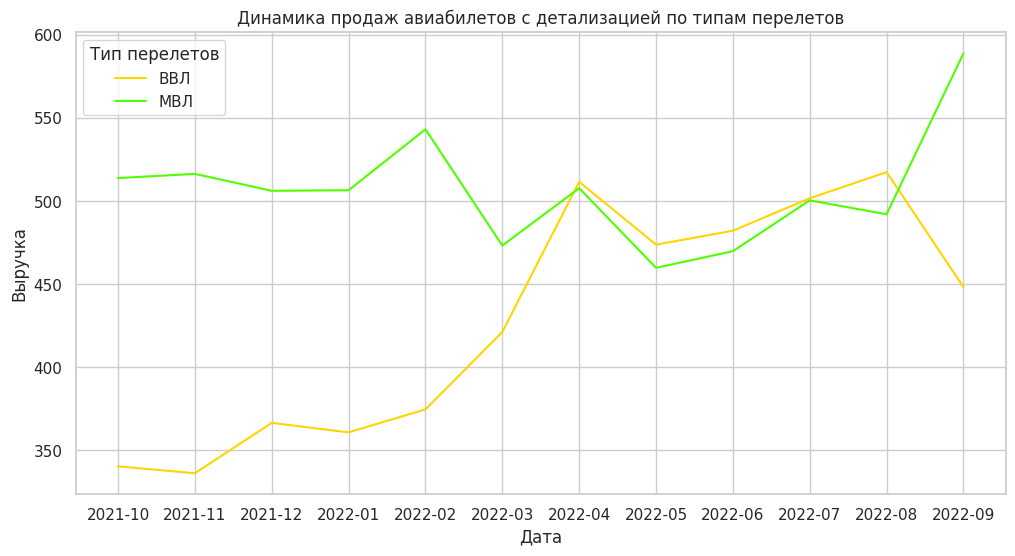

In [24]:
for col in report_type.columns[1:]:
    sns.lineplot(data = report_type, x = 'year_month', y = col, label = col)
plt.legend(title = 'Тип перелетов')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Динамика продаж авиабилетов с детализацией по типам перелетов')
plt.show()

Как и ожидалось, стоимость международных перелетов выше, чем стоимость внутренних, однако интересно, что апреля по август 2022 стоимость была примерно одинаковая, возможно, дело в политических шоках и роста издержек для внутренних перелетов

In [25]:
# Посмотрим, как обстоит дела со средней выручкой по типу покупок
report_sale = df.pivot_table(index = 'year_month',
                        values = 'revenue_amount',
                        aggfunc = 'mean',
                         columns = 'sale_type').reset_index()
report_sale

sale_type,year_month,OFFLINE,ONLINE
0,2021-10,409.350977,334.418146
1,2021-11,402.654155,323.830948
2,2021-12,426.738369,352.377241
3,2022-01,419.006044,346.900000
4,2022-02,427.461735,359.421751
5,2022-03,463.071553,395.247411
6,2022-04,538.828735,485.864588
7,2022-05,517.446068,444.043040
8,2022-06,504.789015,462.822581
9,2022-07,541.186673,473.497392


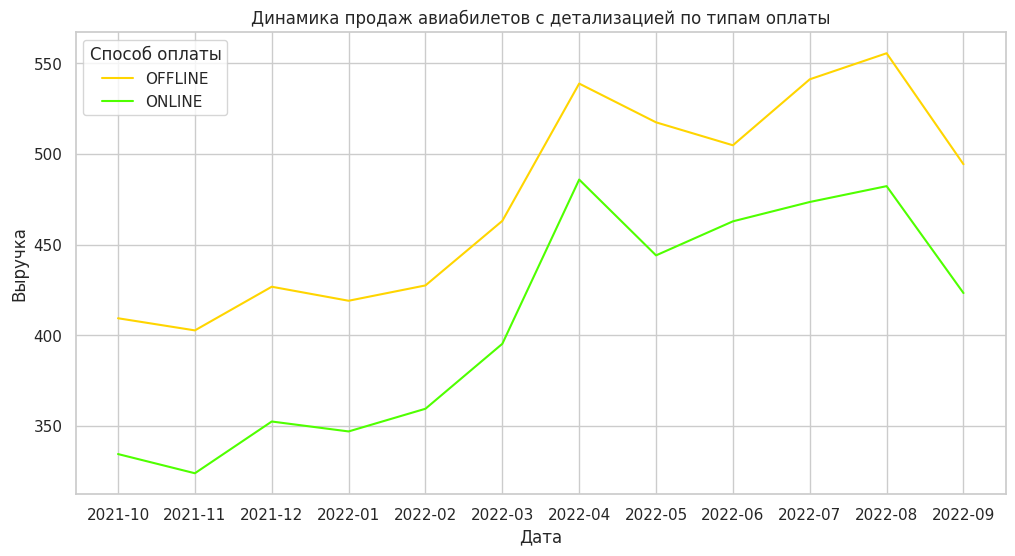

In [26]:
for col in report_sale.columns[1:]:
    sns.lineplot(data = report_sale, x = 'year_month', y = col, label = col)
plt.legend(title = 'Способ оплаты')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Динамика продаж авиабилетов с детализацией по типам оплаты')
plt.show()

Покупая билеты через интернет, люди в среднем платят меньше, динамика схожая

## 3.2 Исследование выручки на выбросы

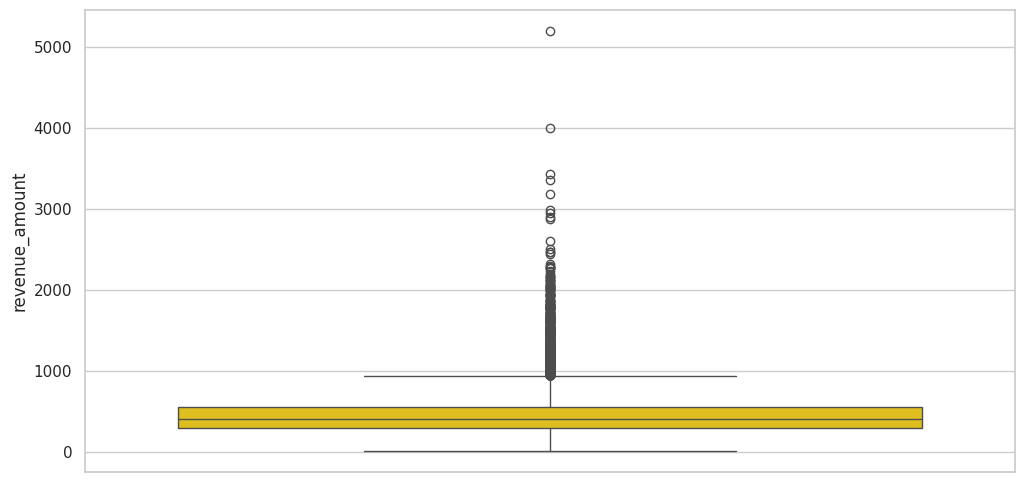

In [27]:
sns.boxplot(df['revenue_amount'])
plt.show()

In [28]:
# Посмотрим, сколько у нас выбросов в процентном соотношении
q1 = np.percentile(df['revenue_amount'], 25)
q3 = np.percentile(df['revenue_amount'], 75)
iqr = 1.5*(q3 - q1)
low_bound = q1 - iqr
upp_bound = q3 + iqr
print('Выбросы составили ', (1 - len(df.query("@low_bound < revenue_amount < @upp_bound"))/len(df))*100, '% от всей выручки')

Выбросы составили  2.1109355374579586 % от всей выручки


2% - это значительная часть датасета, применим более щадящий метод 3 межквартильных размахов

In [29]:
# Посмотрим, сколько у нас выбросов в процентном соотношении
q1 = np.percentile(df['revenue_amount'], 25)
q3 = np.percentile(df['revenue_amount'], 75)
iqr = 3*(q3 - q1)
low_bound = q1 - iqr
upp_bound = q3 + iqr
print('Выбросы составили ', (1 - len(df.query("@low_bound < revenue_amount < @upp_bound"))/len(df))*100, '% от всей выручки')

Выбросы составили  0.4193509177099819 % от всей выручки


Как видно, большинство выбросов по выручке происходит в случае международных перелетов, что естественно для них, возможно стоит удалять выбросы по отдельности

Выбросов меньше половины процента, такое количество данных допустимо удалить

In [30]:
df_new = df.query("@low_bound < revenue_amount < @upp_bound")

In [31]:
df_new['issue_date'].dt.month

0        12
1        12
2        11
3        12
4        12
         ..
49992     6
49993     6
49994     6
49995     6
49996     6
Name: issue_date, Length: 49155, dtype: int32

## 3.3 Исследуем сезонность продаж

In [32]:
# Добавим столбец с сезонностью
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
df_new['season'] = df_new['issue_date'].apply(get_season)

<ipython-input-32-58853dd66a76>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['season'] = df_new['issue_date'].apply(get_season)


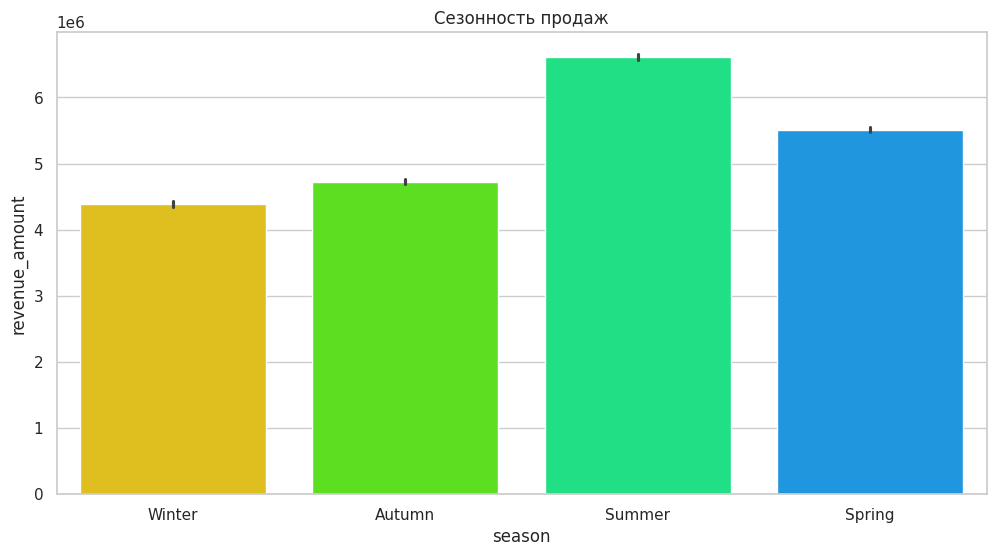

In [33]:
sns.barplot(data = df_new, y = 'revenue_amount', x = 'season', hue = 'season', estimator = sum)
plt.title('Сезонность продаж')
plt.show()

Как мы видим, осенью и зимой достаточно низкая стоимость билетов, а летом самая высокая

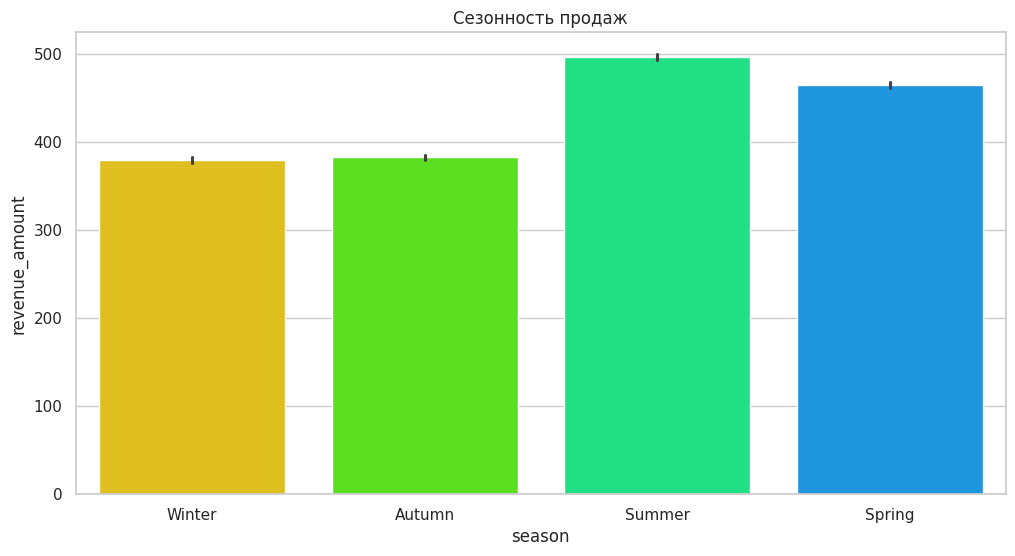

In [34]:
# Проверим, как обстоят дела со средней стоимостью билетов
sns.barplot(data = df_new, y = 'revenue_amount', x = 'season', hue = 'season')
plt.title('Сезонность продаж')
plt.show()

По средним ценам, в целом, сохраняется примерно такое же соотношение, однако тут появляется гипотеза о равенстве средних цен билетов осенью и зимой. так как визуально, доверительные интервалы средних пересекаются

### 3.3.1 Проверка различия выручки зимой и осенью

In [35]:
alpha = 0.05

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Р значение: 0.0
autumn распреден ненормально, отвергаем нулевую гипотезу


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Р значение: 0.0
winter распреден ненормально, отвергаем нулевую гипотезу


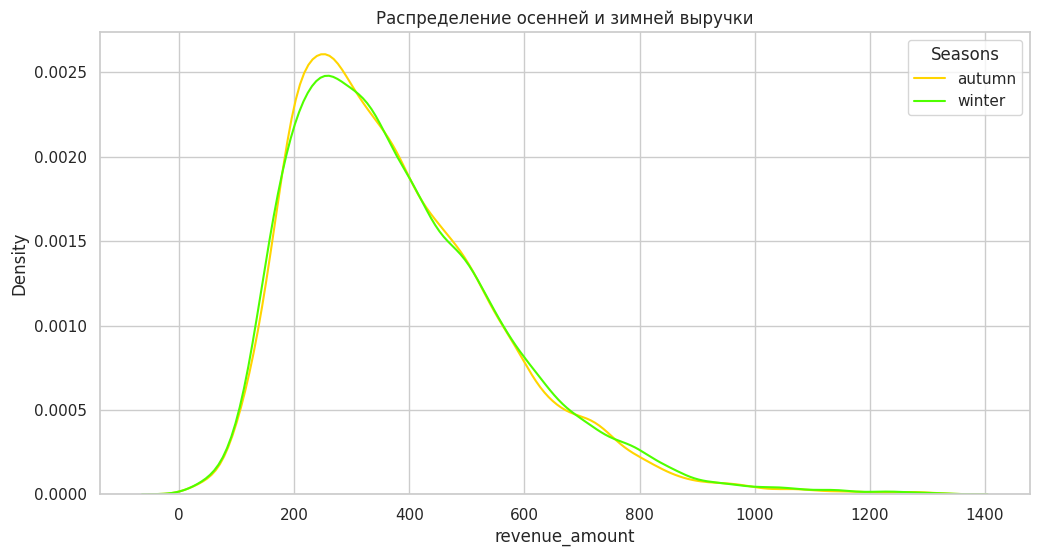

In [36]:
#Проверим выборки на нормальность
autumn = df_new.query('season == "Winter"')['revenue_amount']
winter = df_new.query('season == "Autumn"')['revenue_amount']
for season, label in zip([autumn, winter], ['autumn', 'winter']):
    stat, p = st.shapiro(season)
    print(f'Р значение: {p}')
    if p < alpha:
        print(f'{label} распреден ненормально, отвергаем нулевую гипотезу')
    else:
        print(f'{label} распреден нормально, нет оснований отвергнуть нулевую гипотезу')
    sns.kdeplot(season, label = label)
plt.legend(title = 'Seasons')
plt.ylabel('Density')
plt.title('Распределение осенней и зимней выручки')
plt.show()

Распределения достаточно схожи, однако они не являются нормальными, поэтому проведем ранговый тест Манна-Уитни

In [37]:
stat, p = st.mannwhitneyu(autumn, winter)
print('P-value = ',p)
if p < alpha:
    print(f'Отвергаем нулевую гипотезу, продажи осенью и зимой различаются')
else:
    print(f'Принимаем нулевую гипотезу, продажи зимой и осенью не различаются')

P-value =  0.40257724913500603
Принимаем нулевую гипотезу, продажи зимой и осенью не различаются


### 3.3.2 Исследование выручки и числа продаж по месяцам

<ipython-input-38-c14410d973ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['month'] = df_new['issue_date'].dt.month


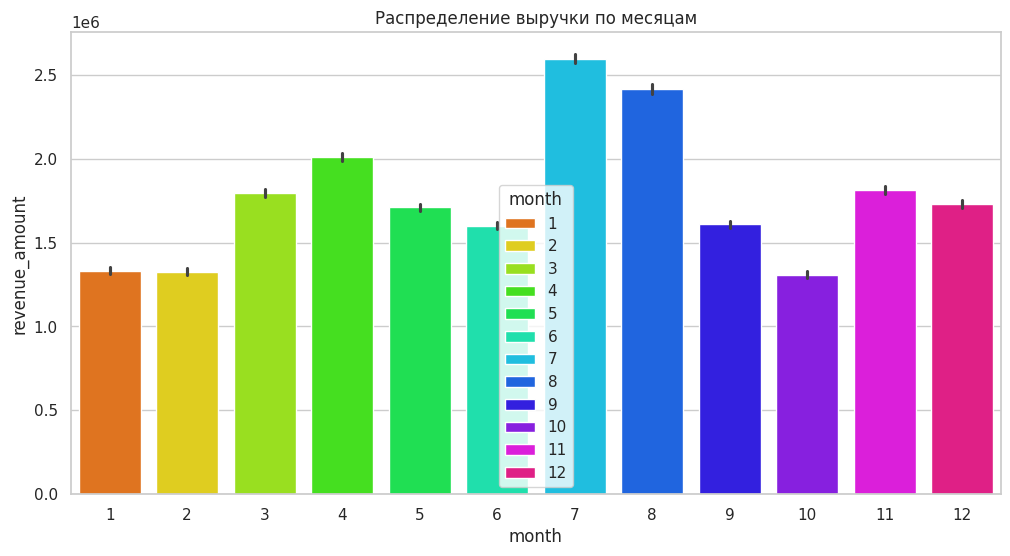

In [38]:
palette = sns.color_palette("hsv", 12)
df_new['month'] = df_new['issue_date'].dt.month
sns.barplot(data = df_new,y = 'revenue_amount', x = 'month', hue = 'month', palette = palette, estimator = sum)
plt.title('Распределение выручки по месяцам')
plt.show()

Самая высокая выручка наблюдается в июле, а самые низкие в январе, феврале и октябре

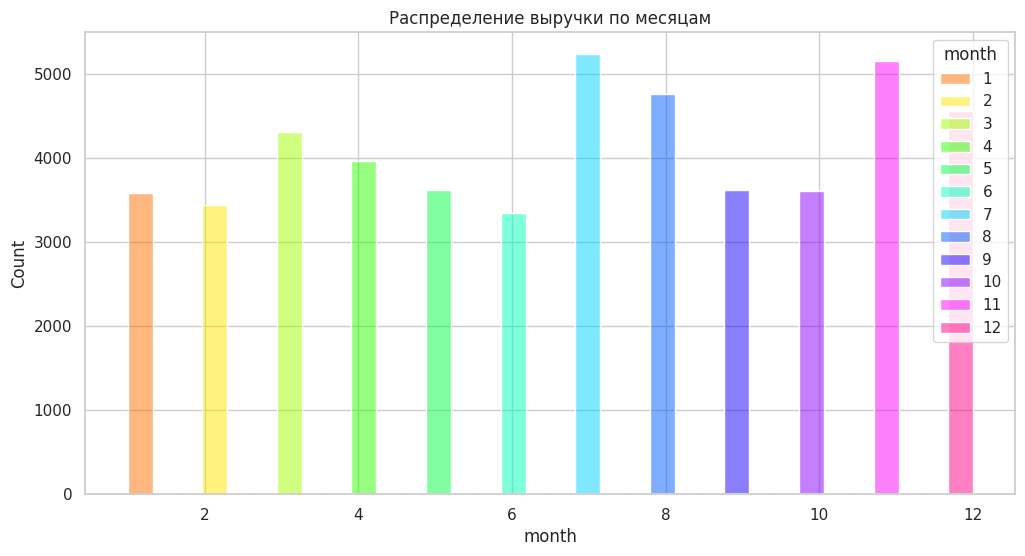

In [39]:
#Посмотрим количество продаж по месяцам
sns.histplot(data = df_new, x = 'month', hue = 'month', palette = palette)
plt.title('Распределение выручки по месяцам')
plt.show()

Количество продаж оказывается самым высоким в июле, однако также видно, что очень много билетов продается и в ноябре, а меньше всего в феврале и июне

<Axes: >

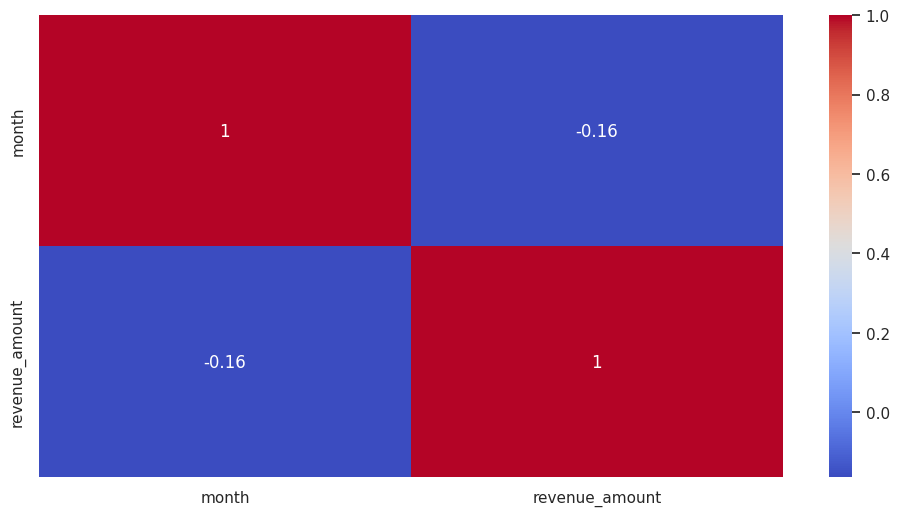

In [40]:
corr = df_new.pivot_table(index = 'month',
              values = 'revenue_amount',
                     aggfunc = 'mean').reset_index().corr()
sns.heatmap(data = corr, annot = True, cmap = 'coolwarm')

Наблюдается слабая отрицательная взаимосвязь - чем больше номер месяца - тем дешевле билеты

<Axes: >

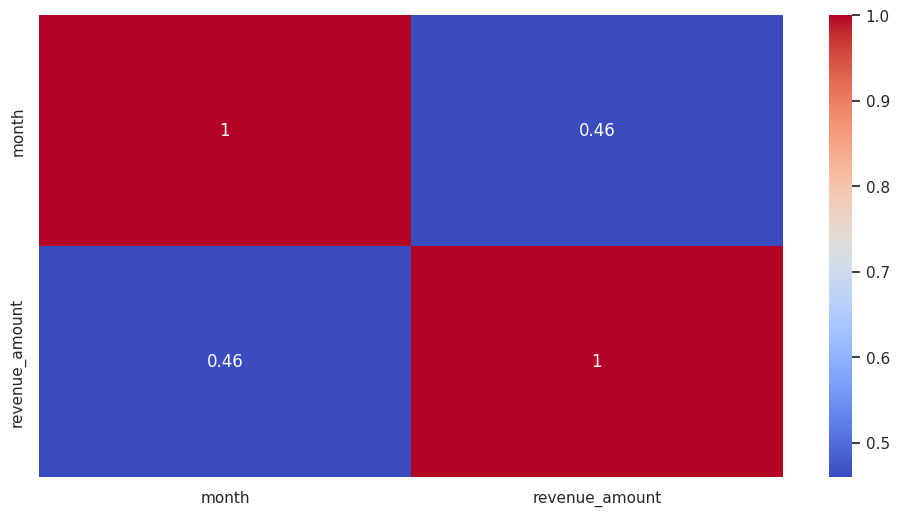

In [41]:
corr = df_new.pivot_table(index = 'month',
              values = 'revenue_amount',
                     aggfunc = 'count').reset_index().corr()
sns.heatmap(data = corr, annot = True, cmap = 'coolwarm')

Наблюдается умеренная положительная зависимость - чем больше номер месяца, тем больше продаж

## 3.4 Проверка выгодности стратегии ранней покупки

In [42]:
df_new['difference_days'] = (df_new['flight_date_loc'] -  df_new['issue_date']).dt.days

<ipython-input-42-f0d6df47b2af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['difference_days'] = (df_new['flight_date_loc'] -  df_new['issue_date']).dt.days


In [43]:
# Разделим покупателей на 4 группы
percentile_25 = np.percentile(df_new['difference_days'], 25)
percentile_50 = np.percentile(df_new['difference_days'], 50)
percentile_75 = np.percentile(df_new['difference_days'], 75)
def get_group(days):
    if days < percentile_25:
        return 'В последний момент'
    elif days < percentile_50:
        return 'Немного заранее'
    elif days < percentile_75:
        return 'Сильно заранее'
    else:
        return 'долгострочные стратеги'
df_new['strategy'] = df_new['difference_days'].apply(get_group)

<ipython-input-43-061062866196>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['strategy'] = df_new['difference_days'].apply(get_group)


H0: Стоимость билетов ничем не отличается
H1: Стоимость билетов различна

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Р значение: 0.0
покупки впоследний момент распреден ненормально, отвергаем нулевую гипотезу
Р значение: 6.691606543705656e-40
покупки по долгострочной стратегии распреден ненормально, отвергаем нулевую гипотезу


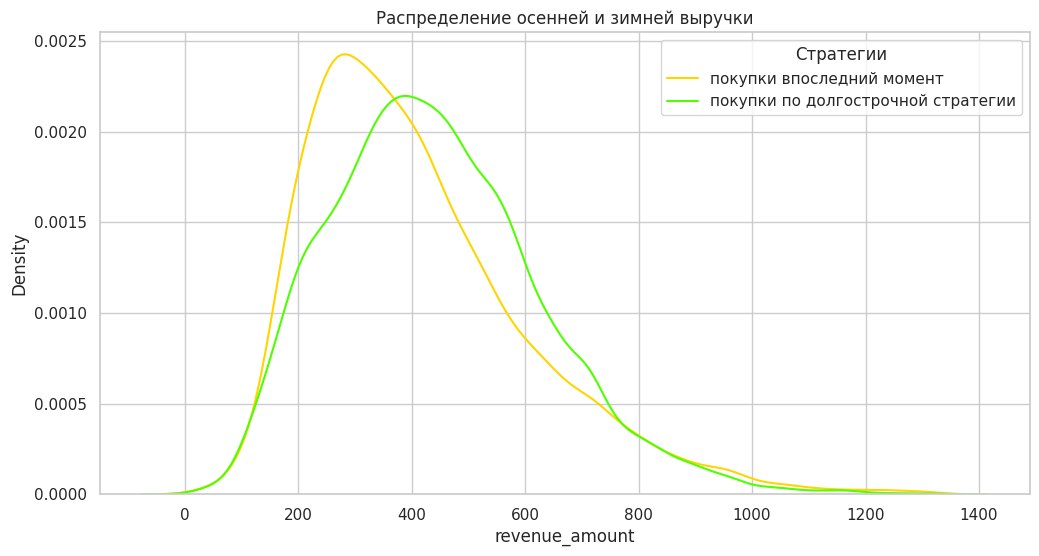

In [44]:
#Проверим выборки на нормальность
short = df_new.query('strategy == "В последний момент"')['revenue_amount']
long = df_new.query('strategy == "долгострочные стратеги"')['revenue_amount']
for strategy, label in zip([short, long], ['покупки впоследний момент', 'покупки по долгострочной стратегии']):
    stat, p = st.shapiro(strategy)
    print(f'Р значение: {p}')
    if p < alpha:
        print(f'{label} распреден ненормально, отвергаем нулевую гипотезу')
    else:
        print(f'{label} распреден нормально, нет оснований отвергнуть нулевую гипотезу')
    sns.kdeplot(strategy, label = label)
plt.legend(title = 'Стратегии')
plt.ylabel('Density')
plt.title('Распределение осенней и зимней выручки')
plt.show()

Данные распределены не нормально, для проверки гипотезы используем тест манна уитни

In [45]:
stat, p = st.mannwhitneyu(short, long)
print('P-value = ',p)
if p < alpha:
    print(f'Отвергаем нулевую гипотезу, стоимость билетов при покупке в последний момент и в долгой стратегии различаются')
else:
    print(f'Принимаем нулевую гипотезу, стоимость билетов в долгой и короткой стратегии не различаюстя')
print(f'Средняя стоимоть билетов в короткой стратегии {short.mean()}')
print(f'Средняя стоимоть билетов в длинной стратегии {long.mean()}')

P-value =  1.923528465204273e-53
Отвергаем нулевую гипотезу, стоимость билетов при покупке в последний момент и в долгой стратегии различаются
Средняя стоимоть билетов в короткой стратегии 412.9082082965578
Средняя стоимоть билетов в длинной стратегии 442.2409190194968


КАк мы видим, покупать билеты в последний момент оказывается даже выгоднее, чем сильно заранее

## 3.5 Определим топ-10 популярных направлений перелетов

In [46]:
# загрузим датасет
column_names = ['Airport Name', 'Location', 'Country', 'IATA_Code', 'ICAO_Code', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Timezone Region', 'Type', 'Source']
data = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', names = column_names)

In [47]:
data

,Airport Name,Location,Country,IATA_Code,ICAO_Code,Latitude,Longitude,Altitude,Timezone,DST,Timezone Region,Type,Source
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


In [48]:
data1 = data[['Location', 'IATA_Code']]

In [49]:
df_new.head()

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year_month,season,month,difference_days,strategy
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,NO,ONLINE,2021-12,Winter,12,35,долгострочные стратеги
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,NO,OFFLINE,2021-12,Winter,12,3,Немного заранее
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE,2021-11,Autumn,11,37,долгострочные стратеги
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,NO,ONLINE,2021-12,Winter,12,28,долгострочные стратеги
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE,2021-12,Winter,12,35,долгострочные стратеги


In [50]:
data1['Location'].unique()

array(['Goroka', 'Madang', 'Mount Hagen', ..., 'Ulan Ude', 'Novgorod',
       'Melitopol'], dtype=object)

In [51]:
# Объединим датасеты
df_general = df_new.merge(data1, how = 'left', left_on = 'orig_city_code', right_on = 'IATA_Code')
df_general = df_general.rename(columns = {'Location': 'orig_location'})
df_general = df_general.drop('IATA_Code', axis = 1)
df_general = df_general.merge(data1, how = 'left', left_on = 'dest_city_code', right_on = 'IATA_Code')
df_general = df_general.rename(columns = {'Location': 'dest_location'})
df_general = df_general.drop('IATA_Code', axis = 1)
df_general.head()

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year_month,season,month,difference_days,strategy,orig_location,dest_location
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,NO,ONLINE,2021-12,Winter,12,35,долгострочные стратеги,NaN,Kaliningrad
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,NO,OFFLINE,2021-12,Winter,12,3,Немного заранее,Yuzhno-sakhalinsk,Novosibirsk
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE,2021-11,Autumn,11,37,долгострочные стратеги,Kaliningrad,NaN
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,NO,ONLINE,2021-12,Winter,12,28,долгострочные стратеги,Voronezh,NaN
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE,2021-12,Winter,12,35,долгострочные стратеги,NaN,Krasnodar


In [52]:
df_general.shape

(49155, 16)

Посмотрим какие города пропущены

In [53]:
df_general.query('orig_location.isna()')['orig_city_code'].unique()

array(['MOW', 'PAR', 'BAK', 'ROM', 'SEL', 'BER', 'GRV', 'NQZ', 'OHH',
       'TOX', 'MIL', 'TYO', 'LON'], dtype=object)

In [54]:
df_general.query('dest_location.isna()')['dest_city_code'].unique()

array(['MOW', 'BAK', 'SEL', 'GRV', 'BER', 'TOX', 'NQZ', 'ROM', 'PAR',
       'LON', 'TYO', 'MIL'], dtype=object)

In [55]:
# Сделаем словарь с пропущенными городами
city = {'MOW': 'Moscow', 'PAR': 'Paris', 'BAK': 'Baku', 'ROM': 'Rome','SEL':'Seoul', 'BER': 'Berlin', 'GRV': 'Grozny',
       'NQZ': 'AStana', 'OHH': 'Okha', 'TOX': 'Tobolsk', 'MIL': 'Milan', 'TYO': 'Tokyo', 'LON': 'London'}

In [56]:
# Заполним пропуски
df_general['orig_location'] = df_general['orig_location'].fillna(df_general['orig_city_code'].map(city))
df_general['dest_location'] = df_general['dest_location'].fillna(df_general['dest_city_code'].map(city))

In [57]:
df_general['route'] = df_general['orig_location'] + '--' + df_general['dest_location']

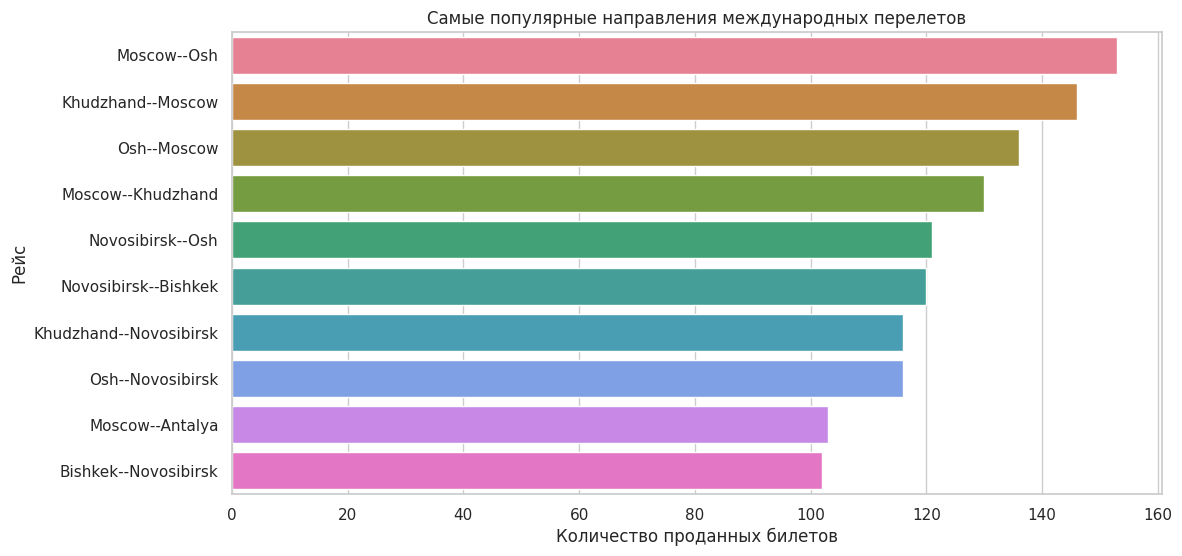

In [58]:
# Самые популярные международные направления
top_international = df_general.query('route_flight_type == "МВЛ"').pivot_table(index = 'route',
                                                                               values = 'revenue_amount',
                                                                               aggfunc = 'count').reset_index().sort_values(by = 'revenue_amount', ascending = False).head(10)
sns.barplot(data = top_international, x = 'revenue_amount', y = 'route', hue = 'route')
plt.title("Самые популярные направления международных перелетов")
plt.xlabel('Количество проданных билетов')
plt.ylabel('Рейс')
plt.show()

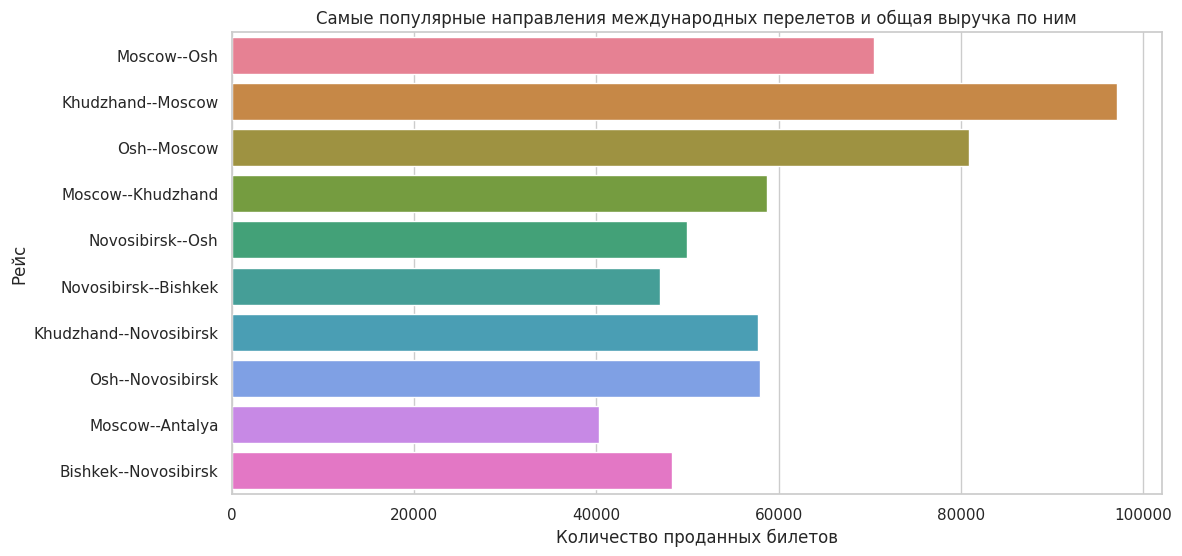

In [59]:
top_international = df_general.query('route_flight_type == "МВЛ"').pivot_table(
    index='route',
    values='revenue_amount',
    aggfunc=['count', 'sum']
).reset_index()
top_international .columns = top_international.columns.droplevel()
top_international.columns =['route', 'count', 'revenue_amount']
top_international = top_international.sort_values(by = 'count', ascending = False).head(10)
sns.barplot(data = top_international, x = 'revenue_amount', y = 'route', hue = 'route')
plt.title("Самые популярные направления международных перелетов и общая выручка по ним")
plt.xlabel('Количество проданных билетов')
plt.ylabel('Рейс')
plt.show()

Больше всего приносит перелеты из Худжана в Москву

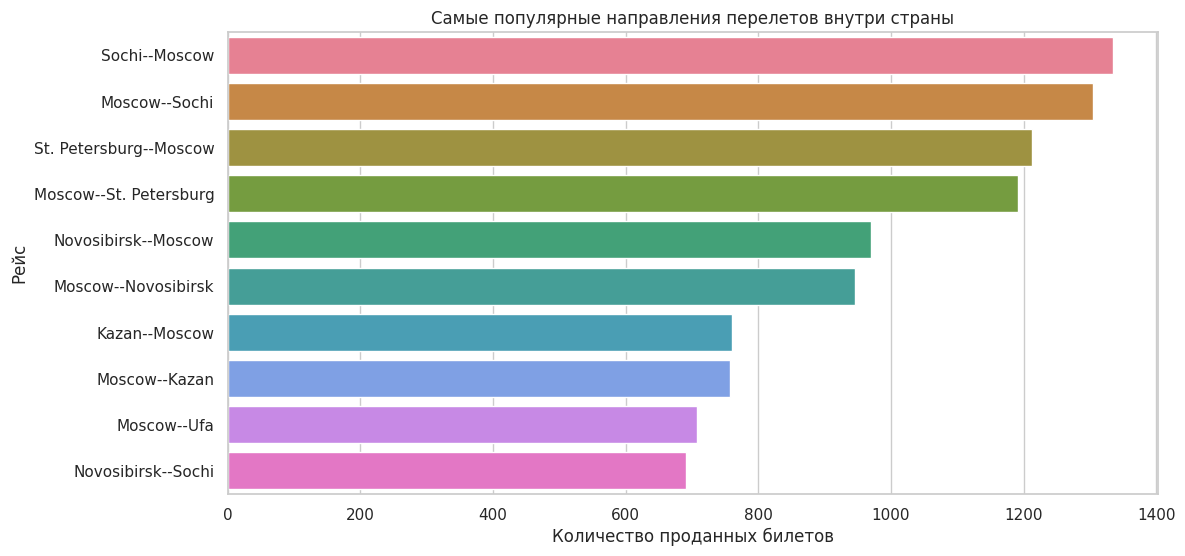

In [60]:
# Самые популярные направления перелета внутри страны
top_internal = df_general.query('route_flight_type == "ВВЛ"').pivot_table(index = 'route',
                                                                               values = 'revenue_amount',
                                                                               aggfunc = 'count').reset_index().sort_values(by = 'revenue_amount', ascending = False).head(10)
sns.barplot(data = top_internal, x = 'revenue_amount', y = 'route', hue = 'route')
plt.title("Самые популярные направления перелетов внутри страны")
plt.xlabel('Количество проданных билетов')
plt.ylabel('Рейс')
plt.show()

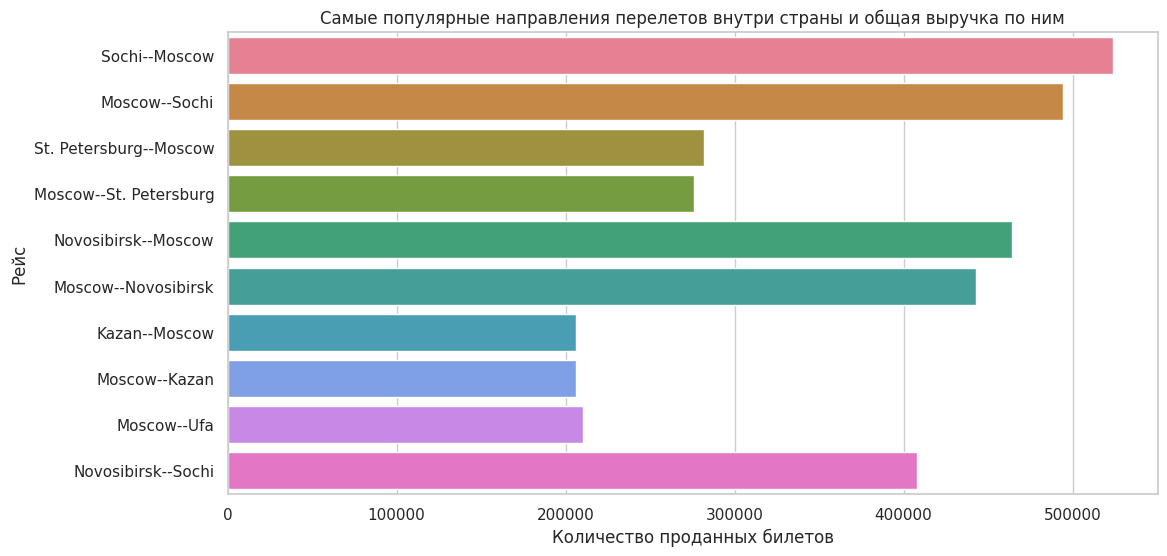

In [61]:
top_internal = df_general.query('route_flight_type == "ВВЛ"').pivot_table(
    index='route',
    values='revenue_amount',
    aggfunc=['count', 'sum']
).reset_index()

# Убираем многоуровневые заголовки
top_internal.columns = top_internal.columns.droplevel()
top_internal.columns =['route', 'count', 'revenue_amount']
top_internal = top_internal.sort_values(by = 'count', ascending = False).head(10)
sns.barplot(data = top_internal, x = 'revenue_amount', y = 'route', hue = 'route')
plt.title("Самые популярные направления перелетов внутри страны и общая выручка по ним")
plt.xlabel('Количество проданных билетов')
plt.ylabel('Рейс')
plt.show()

Можно отметить, что больше всего приносят перелеты в Сочи или в Новосибирск

### 3.5.1 Самые длинные перелеты

In [62]:
data2 = data[['Location', 'IATA_Code', 'Latitude','Longitude']]

In [63]:
# Объединим датасеты
df_general2 = df_new.merge(data2, how = 'left', left_on = 'orig_city_code', right_on = 'IATA_Code')
df_general2 = df_general2.rename(columns = {'Location': 'orig_location', 'Longitude': 'orig_longitude', 'Latitude': 'orig_latitude' })
df_general2 = df_general2.drop('IATA_Code', axis = 1)
df_general2 = df_general2.merge(data2, how = 'left', left_on = 'dest_city_code', right_on = 'IATA_Code')
df_general2 = df_general2.rename(columns = {'Location': 'dest_location', 'Longitude': 'dest_longitude', 'Latitude': 'dest_latitude'})
df_general2 = df_general2.drop('IATA_Code', axis = 1)
df_general2.head()

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year_month,season,month,difference_days,strategy,orig_location,orig_latitude,orig_longitude,dest_location,dest_latitude,dest_longitude
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,NO,ONLINE,2021-12,Winter,12,35,долгострочные стратеги,NaN,NaN,NaN,Kaliningrad,54.889999,20.592600
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,NO,OFFLINE,2021-12,Winter,12,3,Немного заранее,Yuzhno-sakhalinsk,46.888699,142.718002,Novosibirsk,55.012600,82.650703
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE,2021-11,Autumn,11,37,долгострочные стратеги,Kaliningrad,54.889999,20.592600,NaN,NaN,NaN
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,NO,ONLINE,2021-12,Winter,12,28,долгострочные стратеги,Voronezh,51.814201,39.229599,NaN,NaN,NaN
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE,2021-12,Winter,12,35,долгострочные стратеги,NaN,NaN,NaN,Krasnodar,45.034698,39.170502


In [64]:
# Сделаем словарь с пропущенными городами
city = {'MOW': 'Moscow', 'PAR': 'Paris', 'BAK': 'Baku', 'ROM': 'Rome','SEL':'Seoul', 'BER': 'Berlin', 'GRV': 'Grozny',
       'NQZ': 'AStana', 'OHH': 'Okha', 'TOX': 'Tobolsk', 'MIL': 'Milan', 'TYO': 'Tokyo', 'LON': 'London'}
# Добавим словарь с пропущенными широтами
city_latitude = {'MOW': 55.9726, 'PAR': 49.0097, 'BAK': 40.4674, 'ROM': 41.8003, 'SEL': 37.4602, 'BER': 52.3667,
                 'GRV': 43.3881, 'NQZ': 51.0222, 'OHH': 53.5117, 'TOX': 58.1990, 'MIL': 45.6301, 'TYO': 35.7647, 'LON': 51.4700}
# Добавим словарь с пропущенной долготой
city_longitude = {'MOW': 37.4146, 'PAR': 2.5479, 'BAK': 50.0460, 'ROM': 12.2389, 'SEL': 126.4407, 'BER': 13.5033,
                  'GRV': 45.6984, 'NQZ': 71.4669, 'OHH': 142.8898, 'TOX': 68.2543, 'MIL': 8.7231, 'TYO': 140.3864, 'LON': -0.4543}

In [65]:
# Заполним пропуски по городам
df_general2['orig_location'] = df_general2['orig_location'].fillna(df_general2['orig_city_code'].map(city))
df_general2['dest_location'] = df_general2['dest_location'].fillna(df_general2['dest_city_code'].map(city))

# Заполняем пропуски по широте
df_general2['orig_latitude'] = df_general2['orig_latitude'].fillna(df_general2['orig_city_code'].map(city_latitude))
df_general2['dest_latitude'] = df_general2['dest_latitude'].fillna(df_general2['dest_city_code'].map(city_latitude))

# Заполняем пропуски по долготе
df_general2['orig_longitude'] = df_general2['orig_longitude'].fillna(df_general2['orig_city_code'].map(city_longitude))
df_general2['dest_longitude'] = df_general2['dest_longitude'].fillna(df_general2['dest_city_code'].map(city_longitude))

In [66]:
# Создадим рейсы
df_general2['route'] = df_general2.apply(lambda row: '--'.join(sorted([row['orig_location'], row['dest_location']])), axis = 1)

In [67]:
df_general2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49155 entries, 0 to 49154
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   issue_date         49155 non-null  datetime64[ns]
 1   flight_date_loc    49155 non-null  datetime64[ns]
 2   pax_type           49155 non-null  object        
 3   revenue_amount     49155 non-null  int64         
 4   orig_city_code     49155 non-null  object        
 5   dest_city_code     49155 non-null  object        
 6   route_flight_type  49155 non-null  object        
 7   ffp_flag           49155 non-null  object        
 8   sale_type          49155 non-null  object        
 9   year_month         49155 non-null  object        
 10  season             49155 non-null  object        
 11  month              49155 non-null  int32         
 12  difference_days    49155 non-null  int64         
 13  strategy           49155 non-null  object        
 14  orig_l

Все пропуски заполнены

In [68]:
# Установим библиотеку для подсчета расстояний
!pip install geopy

In [69]:
# Импортируем функцию для подсчета расстояний и создадим расчтеный столбец
from geopy.distance import great_circle
df_general2['distance_km'] = df_general2.apply(lambda row: great_circle((row['orig_latitude'], row['orig_longitude']),(row['dest_latitude'], row['dest_longitude'])).kilometers, axis = 1)

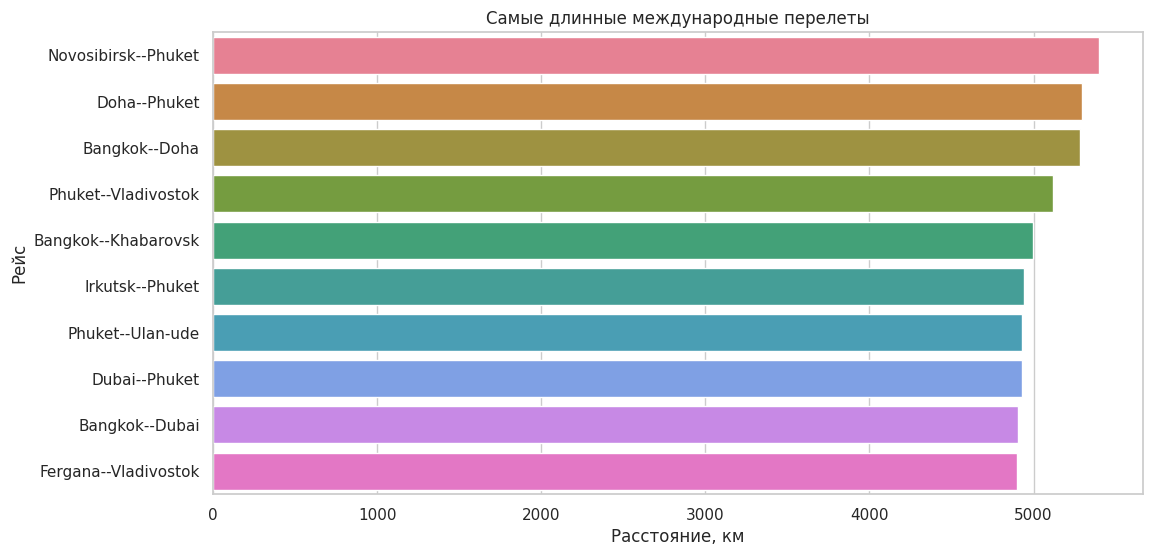

In [70]:
# Самые длинные перелеты на международном направлении
top_international_km = df_general2.query('route_flight_type == "МВЛ"').pivot_table(index = 'route',
                                                                               values = 'distance_km',
                                                                               aggfunc = 'mean').reset_index().sort_values(by = 'distance_km', ascending = False).head(10)
sns.barplot(data = top_international_km, x = 'distance_km', y = 'route', hue = 'route')
plt.title("Самые длинные международные перелеты")
plt.xlabel('Расстояние, км')
plt.ylabel('Рейс')
plt.show()

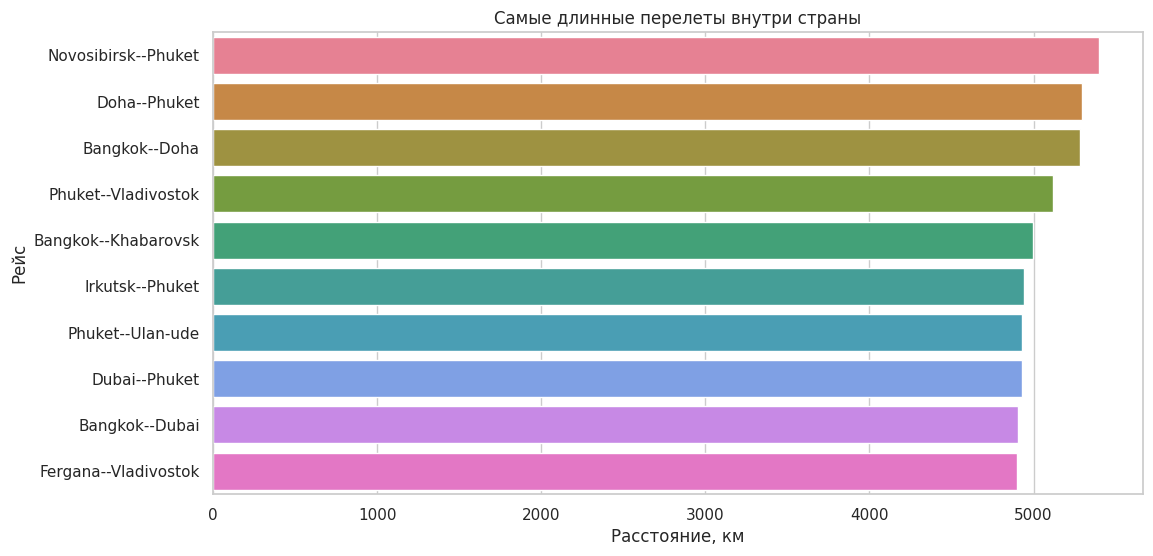

In [71]:
# Самые длинные перелеты внутри страны
top_internal_km = df_general2.query('route_flight_type == "ВВЛ"').pivot_table(index = 'route',
                                                                               values = 'distance_km',
                                                                               aggfunc = 'mean').reset_index().sort_values(by = 'distance_km', ascending = False).head(10)
sns.barplot(data = top_international_km, x = 'distance_km', y = 'route', hue = 'route')
plt.title("Самые длинные перелеты внутри страны")
plt.xlabel('Расстояние, км')
plt.ylabel('Рейс')
plt.show()

Некоторые перелеты внутри страны оказываются длиннее международных, хотя в среднем международные все же длиннее

###3.5.2 Визуализация маршрутов

In [72]:
# Установим библиотеку для визуализации карты
!pip install geopandas --no-warn-script-location

In [73]:
df_general2.columns

Index(['issue_date', 'flight_date_loc', 'pax_type', 'revenue_amount',
       'orig_city_code', 'dest_city_code', 'route_flight_type', 'ffp_flag',
       'sale_type', 'year_month', 'season', 'month', 'difference_days',
       'strategy', 'orig_location', 'orig_latitude', 'orig_longitude',
       'dest_location', 'dest_latitude', 'dest_longitude', 'route',
       'distance_km'],
      dtype='object')

In [74]:
# Импортируем библиотеки для построения карты и нанесения точек и линий
import geopandas as gpd
from shapely.geometry import LineString, Point

In [75]:
# Создадим точки и линии
geometry = [ LineString([Point(row['orig_longitude'], row['orig_latitude']),
             Point(row['dest_longitude'], row['dest_latitude'])])
             for index, row in df_general2.iterrows()]
# Создадим датафрейм для визуализации
geodf = gpd.GeoDataFrame(df_general2[['orig_location', 'orig_latitude', 'orig_longitude',
       'dest_location', 'dest_latitude', 'dest_longitude', 'route',
       'distance_km']], geometry = geometry)

<ipython-input-76-0523804c3c02>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


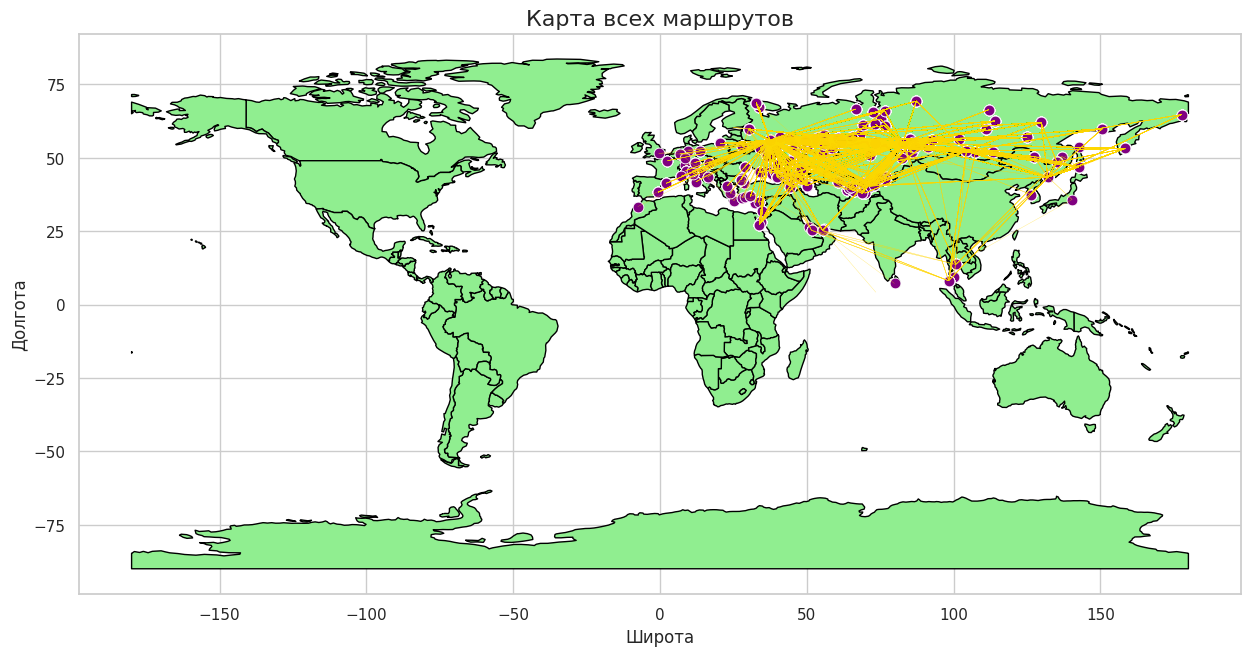

In [76]:
# Создадим сетку для графика
fig, ax = plt.subplots(figsize=(15, 15))
sns.set_palette('husl')
# Зададим карту мира
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgreen', edgecolor='black')
# Отобразим линии
geodf.plot(ax = ax, color = 'gold', linewidth=0.3, alpha=0.5)
# Отображение точек отправления и назначения
sns.scatterplot(data=geodf, x='orig_longitude', y='orig_latitude',
                color='purple', s=60, ax=ax)
# Настройка осей и заголовка
ax.set_xlabel('Широта')
ax.set_ylabel('Долгота')
plt.title('Карта всех маршрутов', fontsize=16)
plt.show()

In [111]:
# Библиотека для сдвига текста
!pip install adjustText

In [112]:
from adjustText import adjust_text

<ipython-input-156-aa80b9a950e5>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


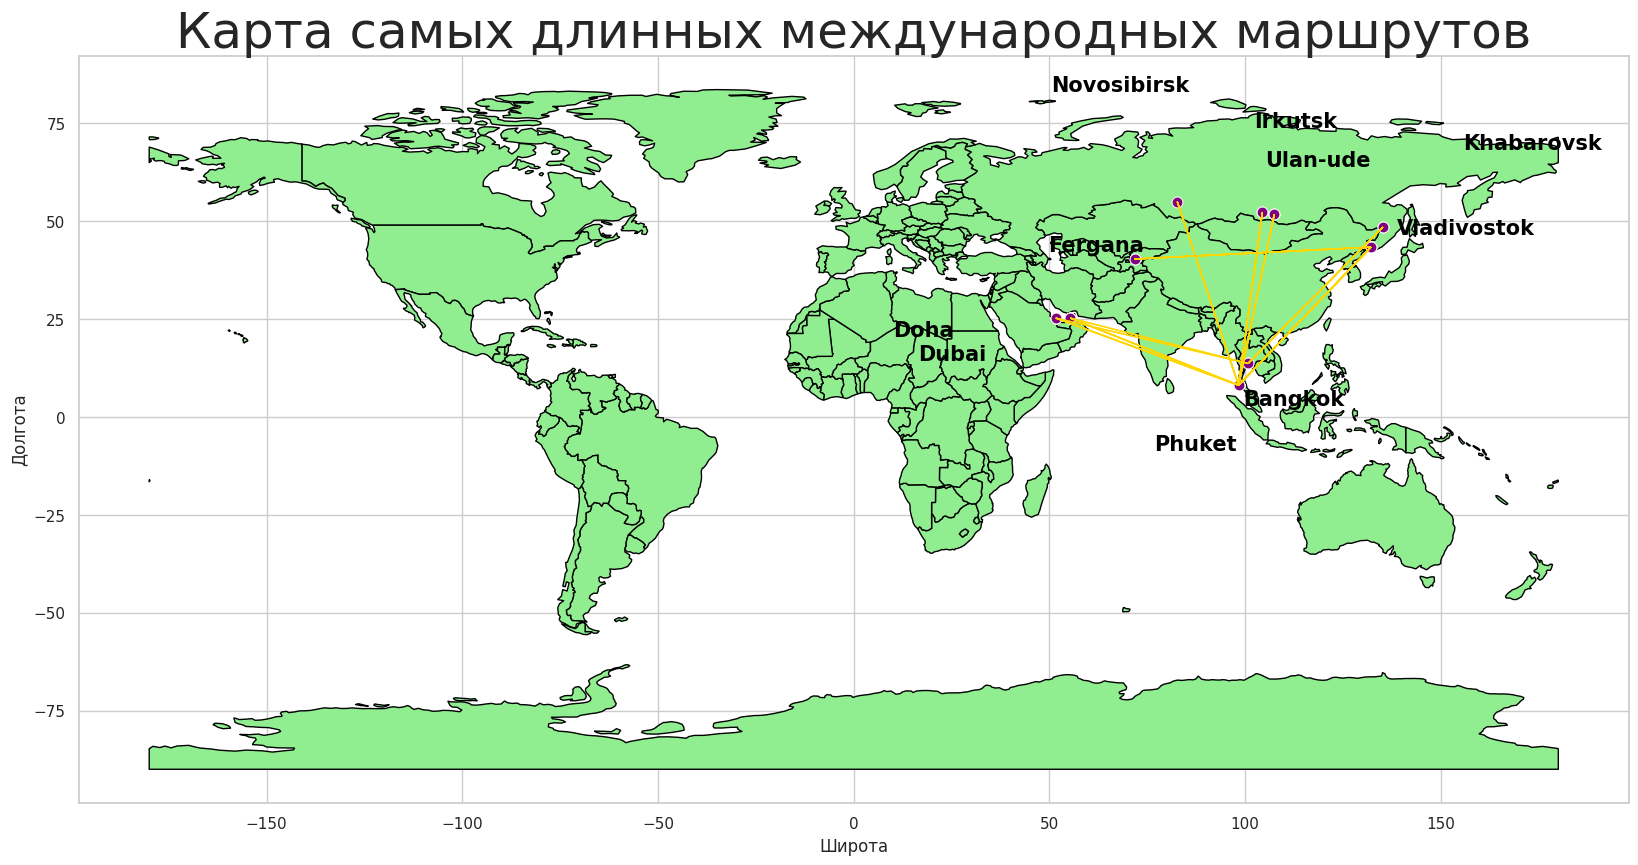

In [156]:
top_international_km_list = top_international_km["route"]
geodf_top_international = geodf.query('route in @top_international_km_list')
# Создадим сетку для графика
fig, ax = plt.subplots(figsize=(20, 15))
# Зададим карту мира
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgreen', edgecolor='black')
# Отобразим линии
geodf_top_international.plot(ax = ax, color = 'gold', linewidth=1, alpha=1)
# Отображение точек отправления и назначения
sns.scatterplot(data=geodf_top_international, x='dest_longitude', y='dest_latitude',
                color='purple', s=60, ax=ax)
# Добавим название городов
texts = []
annotated_cities = []
for index, row in geodf_top_international.iterrows():
  if row['dest_location'] not in annotated_cities:
    texts.append(ax.annotate(row['dest_location'], (row['dest_longitude'], row['dest_latitude']),
              textcoords = 'offset points', xytext = (0,-50), ha = 'center', fontsize = 15, color = 'black', fontweight = 'bold' ))
    annotated_cities.append(row['dest_location'])
# Настройка осей и заголовка
ax.set_xlabel('Широта')
ax.set_ylabel('Долгота')
plt.title('Карта самых длинных международных маршрутов', fontsize=36)
adjust_text(texts, expand_text = 0.01, force_text = 0.00001)
plt.show()

<ipython-input-157-9de20c2b24c7>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


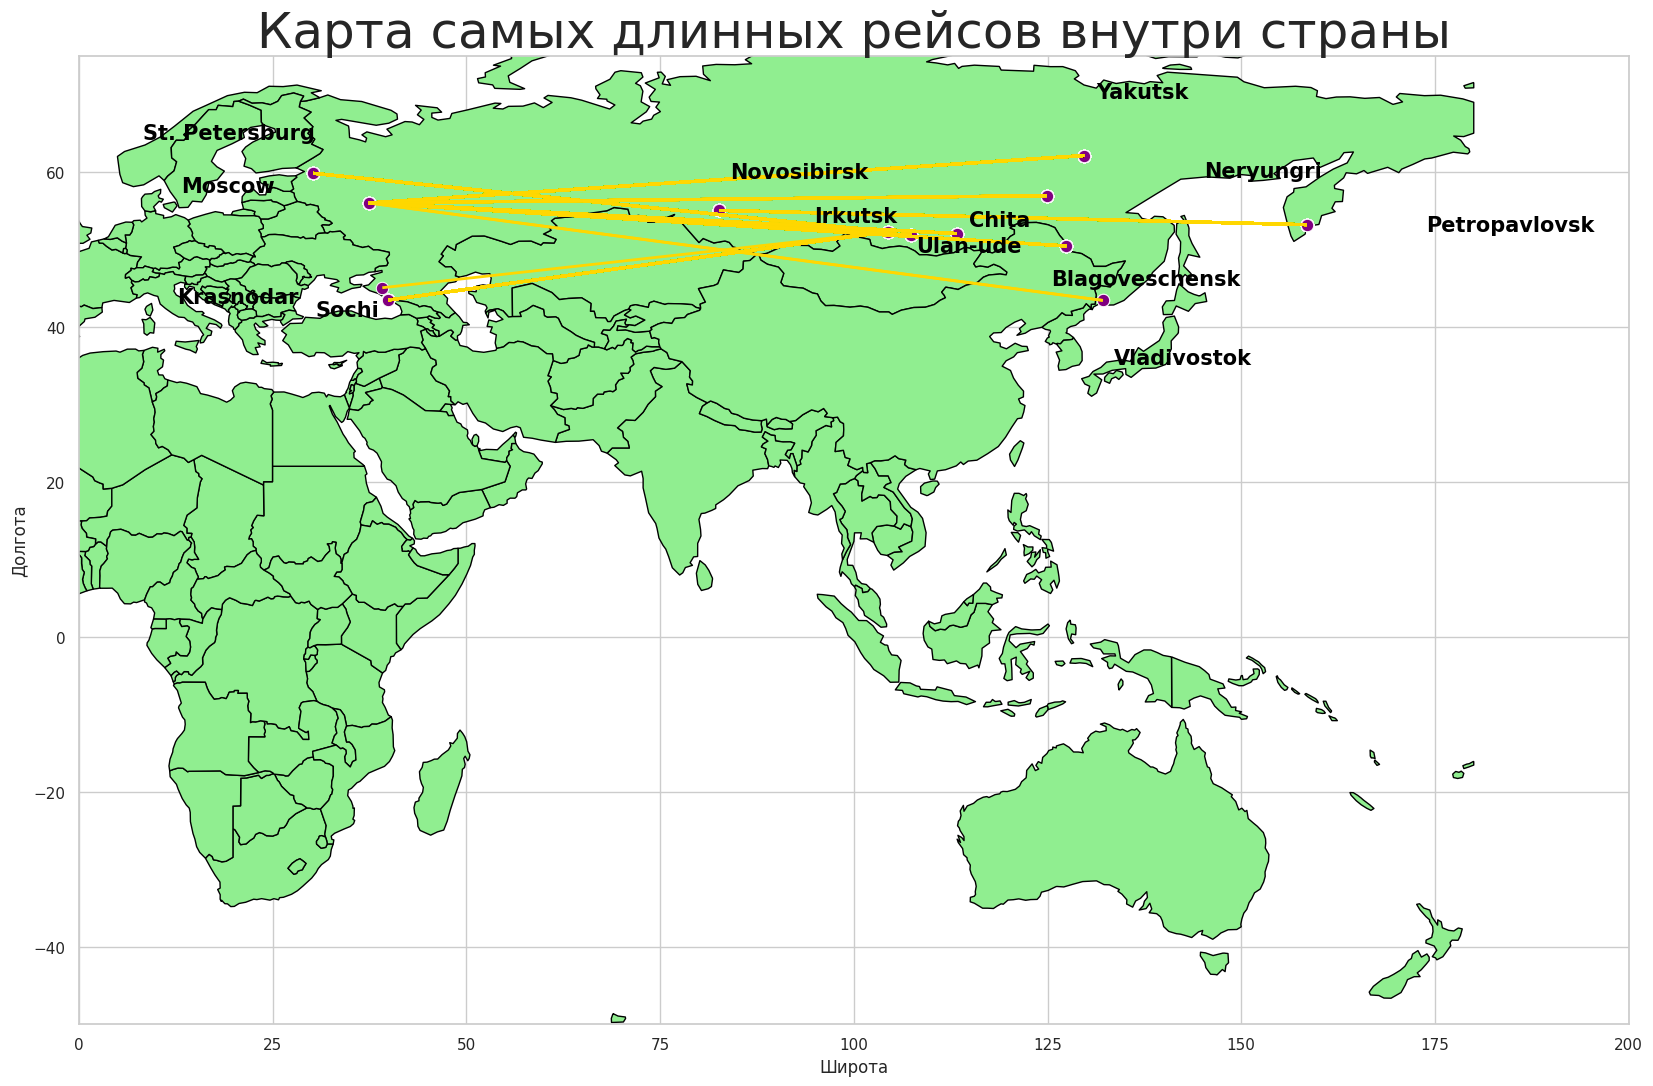

In [157]:
# Рассмотрим внутренние перелеты
top_internal_km_list = top_internal_km["route"]
geodf_top_internal = geodf.query('route in @top_internal_km_list')
# Создадим сетку для графика
fig, ax = plt.subplots(figsize=(20, 15))
# Зададим карту мира
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgreen', edgecolor='black')
# Отобразим линии
geodf_top_internal.plot(ax = ax, color = 'gold', linewidth=2, alpha=1)
# Отображение точек отправления и назначения
sns.scatterplot(data=geodf_top_internal, x='dest_longitude', y='dest_latitude',
                color='purple', s=80, ax=ax)
sns.scatterplot(data=geodf_top_internal, x='orig_longitude', y='orig_latitude',
                color='purple', s=80, ax=ax)
# Добавим название городов
texts = []
annotated_cities = []
for index, row in geodf_top_internal.iterrows():
  if row['dest_location'] not in annotated_cities:
    texts.append(ax.annotate(row['dest_location'], (row['dest_longitude'], row['dest_latitude']),
              textcoords = 'offset points', xytext = (0,0), ha = 'center', fontsize = 15, color = 'black', fontweight = 'bold'))
    annotated_cities.append(row['dest_location'])
  elif row['orig_location'] not in annotated_cities:
    texts.append(ax.annotate(row['orig_location'], (row['orig_longitude'], row['orig_latitude']),
              textcoords = 'offset points', xytext = (0,0), ha = 'center', fontsize = 15, color = 'black', fontweight = 'bold'))
    annotated_cities.append(row['orig_location'])
# Настройка осей и заголовка
ax.set_xlabel('Широта')
ax.set_ylabel('Долгота')
plt.title('Карта самых длинных рейсов внутри страны', fontsize=36)
adjust_text(texts, expand_text = 0.3, force_text = 0.02)
plt.xlim(0,200)
plt.ylim(-50,75)
plt.show()

## 3.6 Влияние прочих факторов

In [82]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49155 entries, 0 to 49154
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   issue_date         49155 non-null  datetime64[ns]
 1   flight_date_loc    49155 non-null  datetime64[ns]
 2   pax_type           49155 non-null  object        
 3   revenue_amount     49155 non-null  int64         
 4   orig_city_code     49155 non-null  object        
 5   dest_city_code     49155 non-null  object        
 6   route_flight_type  49155 non-null  object        
 7   ffp_flag           49155 non-null  object        
 8   sale_type          49155 non-null  object        
 9   year_month         49155 non-null  object        
 10  season             49155 non-null  object        
 11  month              49155 non-null  int32         
 12  difference_days    49155 non-null  int64         
 13  strategy           49155 non-null  object        
 14  orig_l

In [83]:
cat_columns = df_general.select_dtypes(include = 'object').columns.tolist()

In [84]:
cat_columns_new = ['pax_type',
 'route_flight_type',
 'ffp_flag',
 'sale_type',
 'year_month',
 'season',
 'strategy']

In [85]:
# Создадим новый датасет с преобразованными категориальными беременными
df_gen2 = pd.get_dummies(data = df_general, columns = cat_columns_new)

In [86]:
df_gen2

,issue_date,flight_date_loc,revenue_amount,orig_city_code,dest_city_code,month,difference_days,orig_location,dest_location,route,...,year_month_2022-08,year_month_2022-09,season_Autumn,season_Spring,season_Summer,season_Winter,strategy_В последний момент,strategy_Немного заранее,strategy_Сильно заранее,strategy_долгострочные стратеги
0,2021-12-07,2022-01-11,200,MOW,KGD,12,35,Moscow,Kaliningrad,Moscow--Kaliningrad,...,False,False,False,False,False,True,False,False,False,True
1,2021-12-31,2022-01-03,610,UUS,OVB,12,3,Yuzhno-sakhalinsk,Novosibirsk,Yuzhno-sakhalinsk--Novosibirsk,...,False,False,False,False,False,True,False,True,False,False
2,2021-11-28,2022-01-04,390,KGD,MOW,11,37,Kaliningrad,Moscow,Kaliningrad--Moscow,...,False,False,True,False,False,False,False,False,False,True
3,2021-12-08,2022-01-05,190,VOZ,MOW,12,28,Voronezh,Moscow,Voronezh--Moscow,...,False,False,False,False,False,True,False,False,False,True
4,2021-12-08,2022-01-12,190,MOW,KRR,12,35,Moscow,Krasnodar,Moscow--Krasnodar,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49150,2022-06-11,2022-06-22,480,MOW,OMS,6,11,Moscow,Omsk,Moscow--Omsk,...,False,False,False,False,True,False,False,False,True,False
49151,2022-06-06,2022-06-20,270,LED,MOW,6,14,St. Petersburg,Moscow,St. Petersburg--Moscow,...,False,False,False,False,True,False,False,False,True,False
49152,2022-06-26,2022-06-29,230,MOW,KZN,6,3,Moscow,Kazan,Moscow--Kazan,...,False,False,False,False,True,False,False,True,False,False
49153,2022-06-26,2022-06-28,270,KZN,MOW,6,2,Kazan,Moscow,Kazan--Moscow,...,False,False,False,False,True,False,True,False,False,False


In [87]:
num_columns = df_gen2.select_dtypes(include = ['int64', 'bool']).columns.tolist()

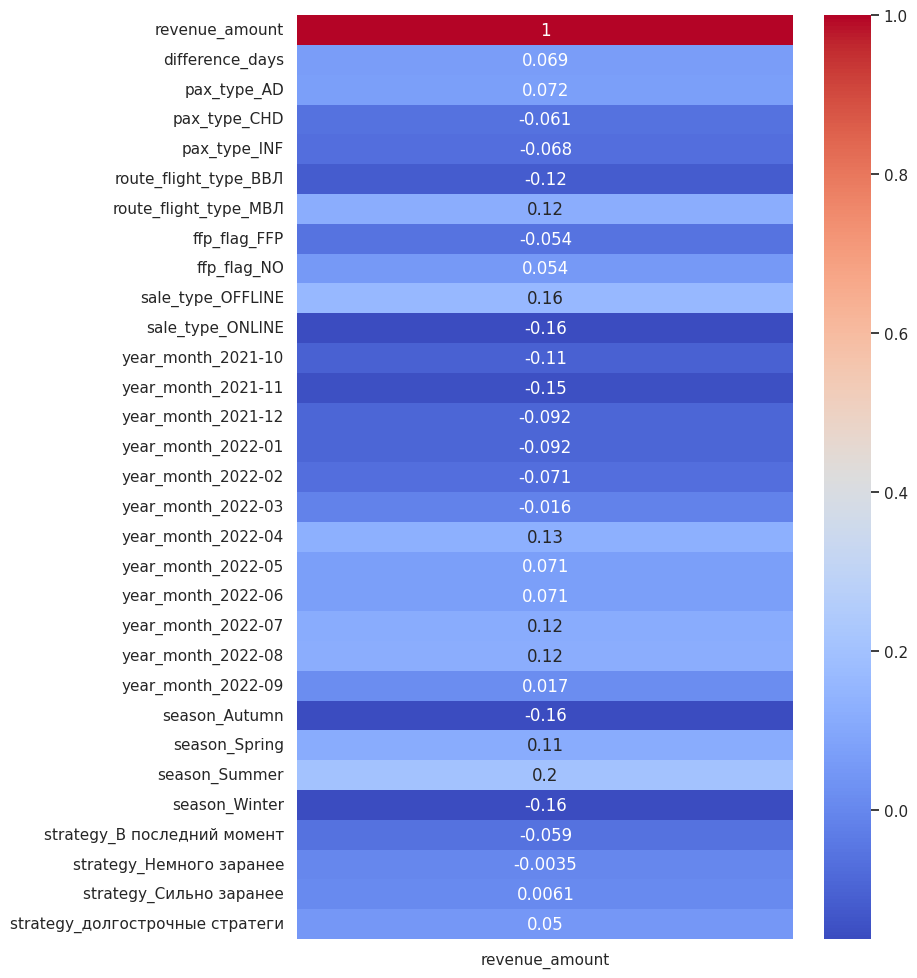

In [88]:
# Так как у нас имеются и количественные данные, кроме того. распределенные не нормально, используем корреляцию спирмена
plt.figure(figsize = (8,12))
corr = df_gen2[num_columns].corr(method = 'spearman')[['revenue_amount']]
sns.heatmap(corr, cmap = 'coolwarm', annot = True)
plt.show()

Все связи довольно слабые, однако будем считать связь значимой, если корреляция по модулю больше 0.1 (по Чеддоку), тогда: наблюдается слабая положительная взаимосвязь выручки с межународными перелетами (0.12), c оплатой в кассе (0.16), апрелем (0.13), июлем и августом (0.13), весной (0.11) и летом (0.2),значимо  негативно на выручку влияют октябрь (-0.11), ноябрь (-0.15), осень и зима (-0.16)

In [159]:
df_gen2.columns

Index(['issue_date', 'flight_date_loc', 'revenue_amount', 'orig_city_code',
       'dest_city_code', 'month', 'difference_days', 'orig_location',
       'dest_location', 'route', 'pax_type_AD', 'pax_type_CHD', 'pax_type_INF',
       'route_flight_type_ВВЛ', 'route_flight_type_МВЛ', 'ffp_flag_FFP',
       'ffp_flag_NO', 'sale_type_OFFLINE', 'sale_type_ONLINE',
       'year_month_2021-10', 'year_month_2021-11', 'year_month_2021-12',
       'year_month_2022-01', 'year_month_2022-02', 'year_month_2022-03',
       'year_month_2022-04', 'year_month_2022-05', 'year_month_2022-06',
       'year_month_2022-07', 'year_month_2022-08', 'year_month_2022-09',
       'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter',
       'strategy_В последний момент', 'strategy_Немного заранее',
       'strategy_Сильно заранее', 'strategy_долгострочные стратеги'],
      dtype='object')

In [163]:
# Рассчитаем бисериальный коэффициент для бинарных данны
for col in df_gen2.columns[10:]:
  result = st.pointbiserialr(df_gen2['revenue_amount'],df_gen2[col])
  print(f'Корреляция выручки и  {col} = {result.correlation}')

Корреляция выручки и  pax_type_AD = 0.07741591678866955
Корреляция выручки и  pax_type_CHD = -0.06706510581322797
Корреляция выручки и  pax_type_INF = -0.06860050045192645
Корреляция выручки и  route_flight_type_ВВЛ = -0.09785598053118882
Корреляция выручки и  route_flight_type_МВЛ = 0.09785598053118885
Корреляция выручки и  ffp_flag_FFP = -0.04711369276459347
Корреляция выручки и  ffp_flag_NO = 0.04711369276459347
Корреляция выручки и  sale_type_OFFLINE = 0.16838848183639404
Корреляция выручки и  sale_type_ONLINE = -0.16838848183639404
Корреляция выручки и  year_month_2021-10 = -0.10006948600048388
Корреляция выручки и  year_month_2021-11 = -0.14083877470622586
Корреляция выручки и  year_month_2021-12 = -0.08498507578468799
Корреляция выручки и  year_month_2022-01 = -0.0865819952137443
Корреляция выручки и  year_month_2022-02 = -0.06588920589813765
Корреляция выручки и  year_month_2022-03 = -0.02424268009519527
Корреляция выручки и  year_month_2022-04 = 0.1147540072375883
Корреляция в

Результаты схожи с коэффициентом Пирсона

In [1]:
numbers = list(range(5))
print(numbers)

[0, 1, 2, 3, 4]


In [2]:
list(range(5))

[0, 1, 2, 3, 4]

In [3]:
range(5)

range(0, 5)